- This notebook is for the postprocessing of calculated data. 
- Both pilot and final data will be used there to create the graphs
and other data mining from them

In [15]:
import pandas as pd
import matplotlib as mlib
import matplotlib.pyplot as plt
import numpy as np
import math

In [16]:
# Load all the pilot data

# gsat
pilot_data_400_gsat = "pdata_res_2022_11_28_03_29_400_gsat2.log"
pilot_data_800_gsat = "pdata_res_2022_11_28_03_29_800_gsat2.log"
pilot_data_1600_gsat = "pdata_res_2022_11_28_03_29_1600_gsat2.log"

# probsat
pilot_data_400_probsat = "pdata_res_2022_11_28_03_29_400_probsat.log"
pilot_data_800_probsat = "pdata_res_2022_11_28_03_29_800_probsat.log"
pilot_data_1600_probsat = "pdata_res_2022_11_28_03_29_1600_probsat.log"

In [17]:
# Read the pilot data
colnames = ["runs", "total_runs", "sat_claus", "total_claus"]
p_df_data = dict()

# Gsat
p_df_data["df_gsat_400"] = pd.read_csv("./results/{}".format(pilot_data_400_gsat), delimiter=" ", names=colnames, header=None)
p_df_data["df_gsat_800"] = pd.read_csv("./results/{}".format(pilot_data_800_gsat), delimiter=" ", names=colnames, header=None)
p_df_data["df_gsat_1600"] = pd.read_csv("./results/{}".format(pilot_data_1600_gsat), delimiter=" ", names=colnames, header=None)

# Probsat
p_df_data["df_probsat_400"] = pd.read_csv("./results/{}".format(pilot_data_400_probsat), delimiter=" ", names=colnames, header=None)
p_df_data["df_probsat_800"] = pd.read_csv("./results/{}".format(pilot_data_800_probsat), delimiter=" ", names=colnames, header=None)
p_df_data["df_probsat_1600"] = pd.read_csv("./results/{}".format(pilot_data_1600_probsat), delimiter=" ", names=colnames, header=None)

In [18]:
# This function extends the data by adding sat column
# the value is true if the clause is satisfied, false otherwise
def extend_cols(df_dict):
    # Create new column with
    for key in df_dict.keys():
        df_dict[key].astype({'runs': 'int', 'total_runs': 'int', 'total_claus': 'int'})
        df_dict[key]["sat"] = ((df_dict[key]["sat_claus"] - df_dict[key]["total_claus"]) == 0)

In [19]:
# Function extracts and caluculates all the info about the data
# There is number of success runs, number of failed, best run number, awg etc..
def get_instances_info(df_set, inst_runs):
    p_df_run = pd.DataFrame({'succ_num':[], 'fail_num': [], 'best_run': [], 'awg_runs': [], 'fined_awg': [], 'q': [], 'o2': []})

    row_num = 0
    succ_num = 0
    best_run = 0
    runs_sum = 0
    q = 0
    o = 0
    o_arr = []
    for index, row in df_set.iterrows():
        row_num += 1
        runs_sum += row['runs']
        o_arr.append(row['runs'])
        
        if row['sat'] == True:
            succ_num += 1
            if row['runs'] == 0:
                q += math.log2(1)
            else:
                q += math.log2(row['runs'])
            
        if row_num == 1 or best_run > row['runs']:
            best_run = row['runs']
        
        if row_num == inst_runs:
            if succ_num != 0:
                q = q / succ_num
            
            if succ_num > 1:
                for runs in o_arr:
                    if runs == 0:
                        runs = 1
                    o += (math.log2(runs) - q)**2
                o = o / (succ_num - 1)
            
            awg_runs = runs_sum / inst_runs
            fined_awg_runs = (runs_sum - (inst_runs - succ_num)*1600 + (inst_runs - succ_num)*16000)/inst_runs
            p_df_run.loc[len(p_df_run.index)] = [succ_num, inst_runs - succ_num, best_run, awg_runs, fined_awg_runs, q, o]
            
            # clean
            row_num = 0
            succ_num = 0
            best_run = 0  
            runs_sum = 0
            q = 0
            o = 0
            o_arr = []
    
    return p_df_run
    

In [20]:
# Function draws the histogram 
def draw_hist(df_one, df_two, col_name, bins_num, x_name, y_name, label_one, label_two, graph_title ):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    # 
    ax.hist(df_one[col_name], bins=bins_num, histtype='step', label=label_one, weights=np.zeros_like(df_one[col_name]) + 1. / df_one.size)
    ax.hist(df_two[col_name], bins=bins_num, histtype='step', label=label_two, weights=np.zeros_like(df_two[col_name]) + 1. / df_two.size)

    ax.set_title(graph_title)
    ax.set_xlabel(x_name, size=10)
    ax.set_ylabel(y_name)
    ax.legend()

    plt.show()

In [21]:
# Function counts the dominance of each dataset over the other one
# using the cdf curve with p value
def dominance_count(df_one, df_two, df_one_name, df_two_name, inst_runs):
    p_df_run = pd.DataFrame({df_one_name:[], df_two_name: []})

    doms_one = 0
    doms_two = 0
    runs_num = 0
    for i in range(0, len(df_one.index), inst_runs):
        runs_num += 1
        
        one_sum = 0
        one_succ = 0
        two_sum = 0
        two_succ = 0
        for j in range(i, i + inst_runs):
            one_sum += df_one.iloc[j]['runs']
            if (df_one.iloc[j]['sat'] == True):
                one_succ += 1
            two_sum += df_two.iloc[j]['runs']
            if (df_two.iloc[j]['sat'] == True):
                two_succ += 1
        
        f_one_sum = 0
        f_two_sum = 0
        temp_one_doms = 0
        temp_two_doms = 0
        for j in range(i, i + inst_runs):
            f_one_sum += df_one.iloc[j]['runs']
            f_two_sum += df_two.iloc[j]['runs']
            
            # cdf
            f_one = f_one_sum / one_sum
            f_two = f_two_sum / two_sum
            
            # p * cdf
            p_one = (one_succ / inst_runs) * f_one
            p_two = (two_succ / inst_runs) * f_two
            
            # Increas dominances
            if (p_one - p_two) > 0:
                temp_one_doms += 1
            elif (p_one - p_two) < 0:
                temp_two_doms += 1
                
        # Increas total dominance
        if temp_one_doms > temp_two_doms:
            doms_one += 1
        elif temp_one_doms < temp_two_doms:
            doms_two += 1
    
    print("one: {} two: {}".format(doms_one, doms_two))
    p_df_run.loc[len(p_df_run.index)] = [doms_one/runs_num, doms_two/runs_num]
    return p_df_run

In [22]:
# Prepare the data
extend_cols(p_df_data)

In [23]:
# Loop shows the number of satisfied clauses for each setting
for key in p_df_data.keys():
    num_sat = p_df_data[key][p_df_data[key]["sat"] == True].shape[0]
    
    print("{}: {}".format(key, num_sat))

df_gsat_400: 19233
df_gsat_800: 21566
df_gsat_1600: 23847
df_probsat_400: 20848
df_probsat_800: 23258
df_probsat_1600: 25252


In [24]:
# Pilot testing 
# Using the df_probsat_1600 datasets
p_df_uf75_325_gsat = p_df_data["df_gsat_1600"][p_df_data["df_gsat_1600"]["total_claus"] == 325]
p_df_uf75_325_probsat = p_df_data["df_probsat_1600"][p_df_data["df_probsat_1600"]["total_claus"] == 325]

In [25]:
p_df_gsat = get_instances_info(p_df_uf75_325_gsat, 100)
p_df_probsat = get_instances_info(p_df_uf75_325_probsat, 100)

In [26]:
p_df_gsat

,succ_num,fail_num,best_run,awg_runs,fined_awg,q,o2
0,29.0,71.0,84.0,1265.38,11489.38,8.484502,12.805131
1,91.0,9.0,37.0,517.34,1813.34,8.148224,2.295154
2,47.0,53.0,67.0,1129.60,8761.60,8.827091,5.179468
3,15.0,85.0,128.0,1494.22,13734.22,9.652754,6.638647
4,78.0,22.0,67.0,727.84,3895.84,8.447660,2.797111
...,...,...,...,...,...,...,...
95,23.0,77.0,84.0,1399.79,12487.79,9.020773,11.169650
96,27.0,73.0,71.0,1348.63,11860.63,9.068216,8.143139
97,83.0,17.0,76.0,746.26,3194.26,8.800429,1.920204
98,52.0,48.0,83.0,1130.15,8042.15,9.016407,4.052901


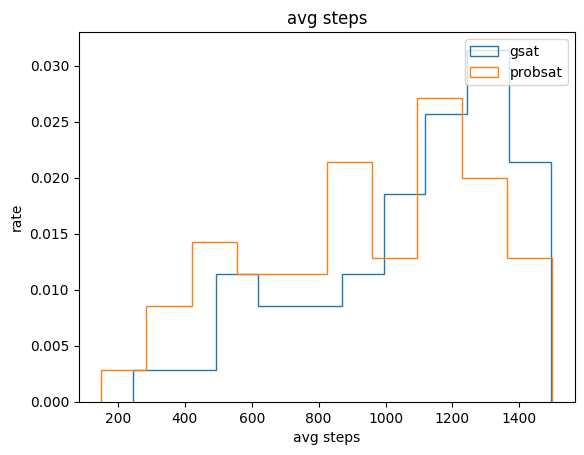

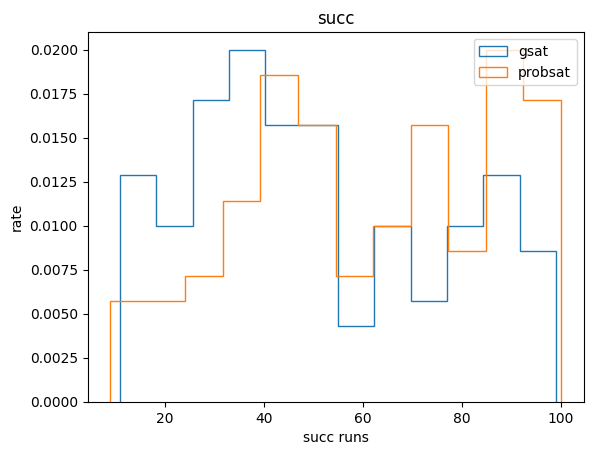

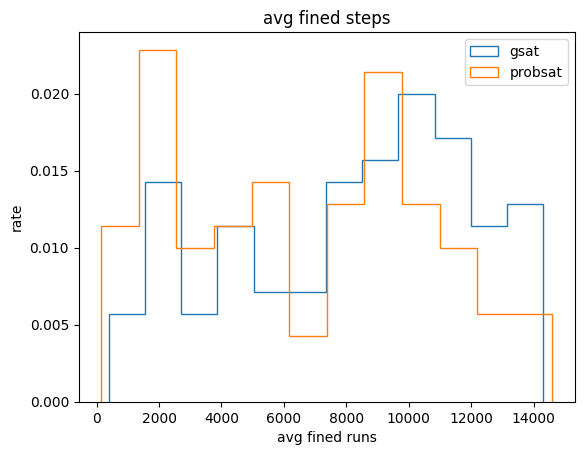

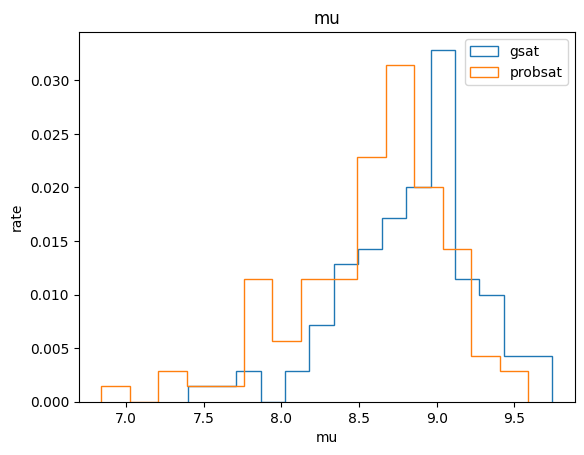

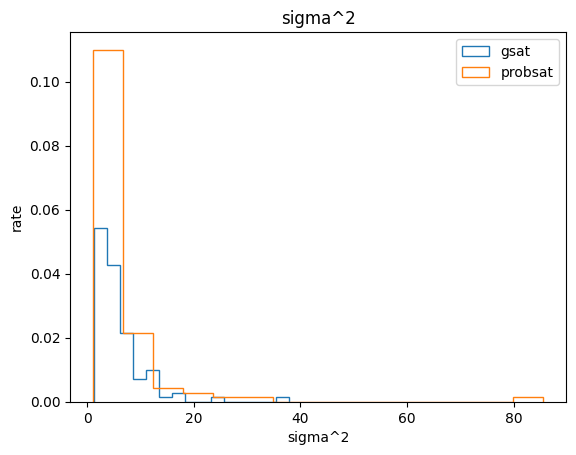

In [43]:
draw_hist(p_df_gsat, p_df_probsat, 'awg_runs', 10, 'avg steps', 'rate', 'gsat', 'probsat', 'avg steps')
draw_hist(p_df_gsat, p_df_probsat, 'succ_num', 12, 'succ runs', 'rate', 'gsat', 'probsat', 'succ')
draw_hist(p_df_gsat, p_df_probsat, 'fined_awg', 12, 'avg fined runs', 'rate', 'gsat', 'probsat', 'avg fined steps')
draw_hist(p_df_gsat, p_df_probsat, 'q', 15, 'mu', 'rate', 'gsat', 'probsat', 'mu')
draw_hist(p_df_gsat, p_df_probsat, 'o2', 15, 'sigma^2', 'rate', 'gsat', 'probsat', 'sigma^2')


one: 86 two: 14


<AxesSubplot: title={'center': 'dominance'}>

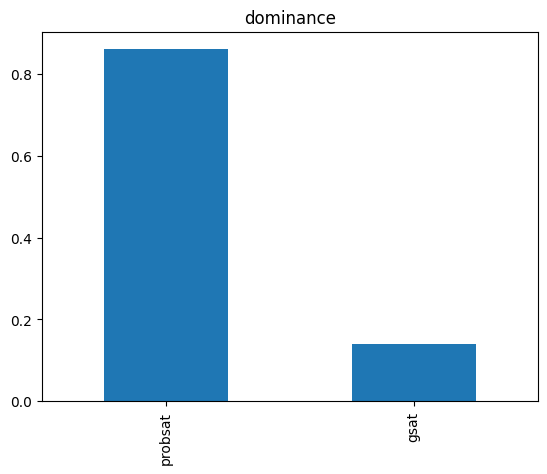

In [28]:
p_df_dom = dominance_count(p_df_uf75_325_probsat, p_df_uf75_325_gsat, 'probsat', 'gsat', 100)
p_df_dom.iloc[0].plot(kind="bar", title="dominance")

In [29]:
# Final testing 

# gsat
final_data_20_gsat = "fdata_res_uf20-91-gsat2.log"
final_data_50_gsat = "fdata_res_uf50-218-gsat2.log"
final_data_75_gsat = "fdata_res_uf75-325_gsat2.log" 

#probsat
final_data_20_probsat = "fdata_res_uf20-91-probsat.log"
final_data_50_probsat = "fdata_res_uf50-218-probsat.log"
final_data_75_probsat = "fdata_res_uf75-325_probsat.log" 


In [30]:
# Read the data
colnames = ["runs", "total_runs", "sat_claus", "total_claus"]
f_df_data = dict()
f_df_data["data_20_gsat"] = pd.read_csv("./results/{}".format(final_data_20_gsat), delimiter=" ", names=colnames, header=None)
f_df_data["data_50_gsat"] = pd.read_csv("./results/{}".format(final_data_50_gsat), delimiter=" ", names=colnames, header=None)
f_df_data["data_75_gsat"] = pd.read_csv("./results/{}".format(final_data_75_gsat), delimiter=" ", names=colnames, header=None)

f_df_data["data_20_probsat"] = pd.read_csv("./results/{}".format(final_data_20_probsat), delimiter=" ", names=colnames, header=None)
f_df_data["data_50_probsat"] = pd.read_csv("./results/{}".format(final_data_50_probsat), delimiter=" ", names=colnames, header=None)
f_df_data["data_75_probsat"] = pd.read_csv("./results/{}".format(final_data_75_probsat), delimiter=" ", names=colnames, header=None)

In [31]:
f_df_data['data_20_probsat']

,runs,total_runs,sat_claus,total_claus
0,34,1600,91,91
1,62,1600,91,91
2,30,1600,91,91
3,47,1600,91,91
4,30,1600,91,91
...,...,...,...,...
499995,8,1600,91,91
499996,20,1600,91,91
499997,34,1600,91,91
499998,22,1600,91,91


In [32]:
extend_cols(f_df_data)

In [33]:
f_df_data['data_20_gsat'][f_df_data['data_20_gsat']['runs'] == 0]

,runs,total_runs,sat_claus,total_claus,sat
29292,0,1600,91,91,True
267140,0,1600,91,91,True
301547,0,1600,91,91,True
330665,0,1600,91,91,True
344301,0,1600,91,91,True
409714,0,1600,91,91,True


In [34]:
# Preprocess data
f_df_20_gsat = get_instances_info(f_df_data['data_20_gsat'], 500)
f_df_20_probsat = get_instances_info(f_df_data['data_20_probsat'], 500)

In [35]:
f_df_50_gsat = get_instances_info(f_df_data['data_50_gsat'], 500)
f_df_50_probsat = get_instances_info(f_df_data['data_50_probsat'], 500)

In [36]:
f_df_75_gsat = get_instances_info(f_df_data['data_75_gsat'], 500)
f_df_75_probsat = get_instances_info(f_df_data['data_75_probsat'], 500)

In [37]:
f_df_20_dom = dominance_count(f_df_data['data_20_probsat'], f_df_data['data_20_gsat'], 'probsat', 'gsat', 500)

one: 485 two: 515


In [38]:
f_df_50_dom = dominance_count(f_df_data['data_50_probsat'], f_df_data['data_50_gsat'], 'probsat', 'gsat', 500)

one: 801 two: 199


In [39]:
f_df_75_dom = dominance_count(f_df_data['data_75_probsat'], f_df_data['data_75_gsat'], 'probsat', 'gsat', 500)

one: 93 two: 7


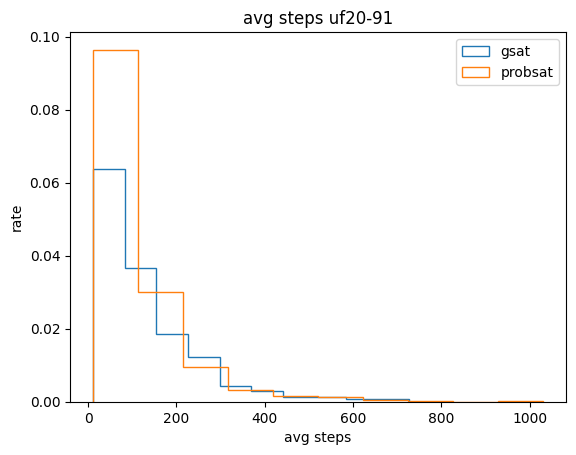

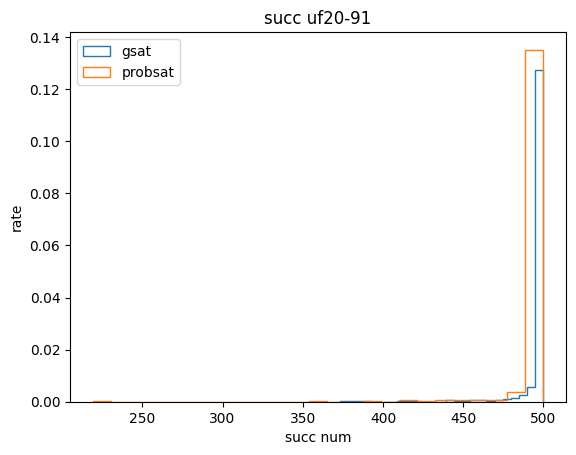

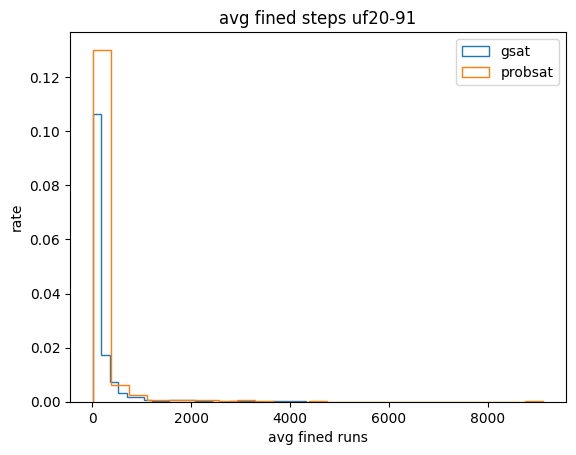

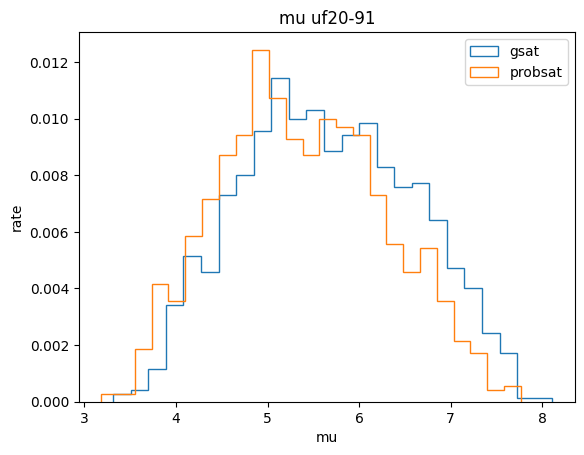

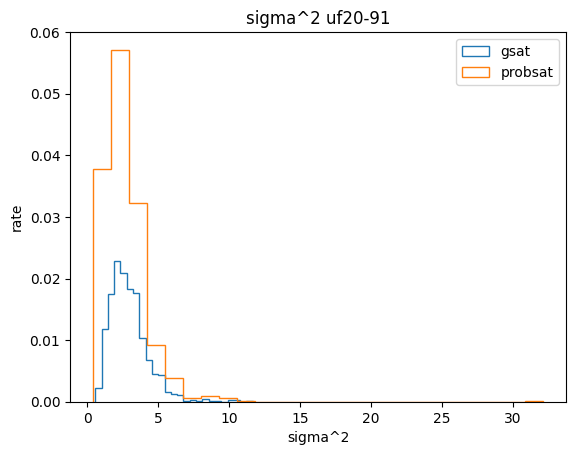

<AxesSubplot: title={'center': 'dominance uf20-91'}>

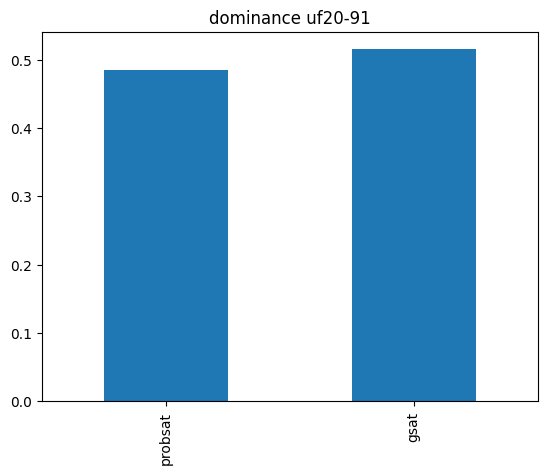

In [47]:
# final graphs for the 20 dataset
draw_hist(f_df_20_gsat, f_df_20_probsat, 'awg_runs', 10, 'avg steps', 'rate', 'gsat', 'probsat', 'avg steps uf20-91')
draw_hist(f_df_20_gsat, f_df_20_probsat, 'succ_num', 25, 'succ num', 'rate', 'gsat', 'probsat', 'succ uf20-91')
draw_hist(f_df_20_gsat, f_df_20_probsat, 'fined_awg', 25, 'avg fined runs', 'rate', 'gsat', 'probsat', 'avg fined steps uf20-91')
draw_hist(f_df_20_gsat, f_df_20_probsat, 'q', 25, 'mu', 'rate', 'gsat', 'probsat', 'mu uf20-91')
draw_hist(f_df_20_gsat, f_df_20_probsat, 'o2', 25, 'sigma^2', 'rate', 'gsat', 'probsat', 'sigma^2 uf20-91')

f_df_20_dom.iloc[0].plot(kind="bar", title="dominance uf20-91")

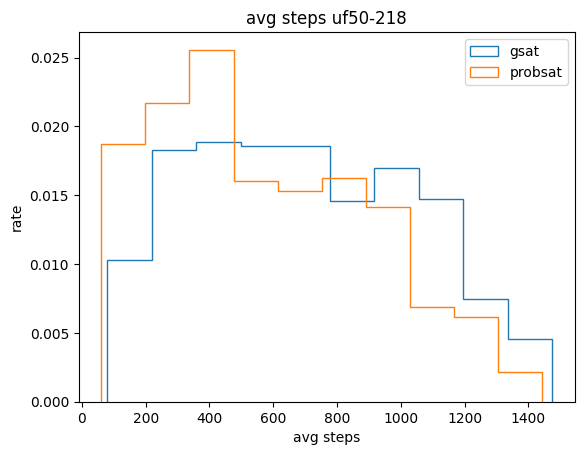

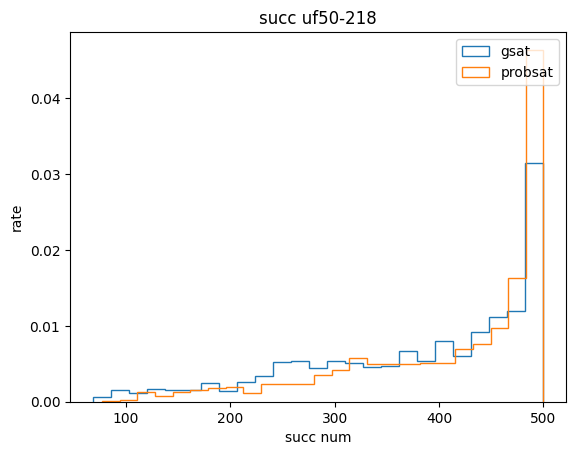

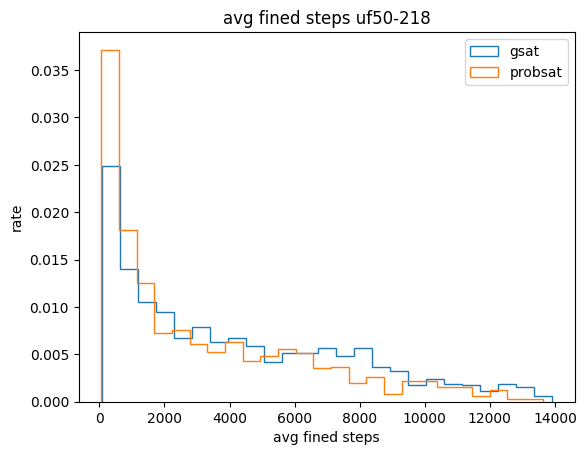

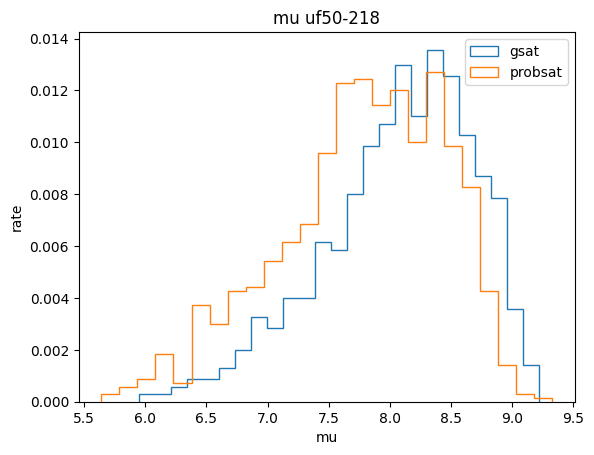

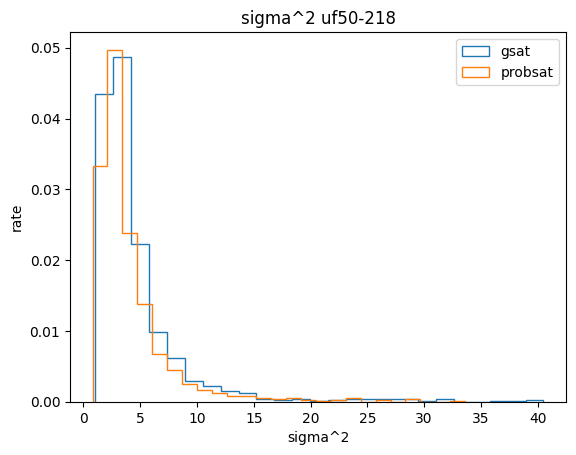

<AxesSubplot: title={'center': 'dominance uf50-218'}>

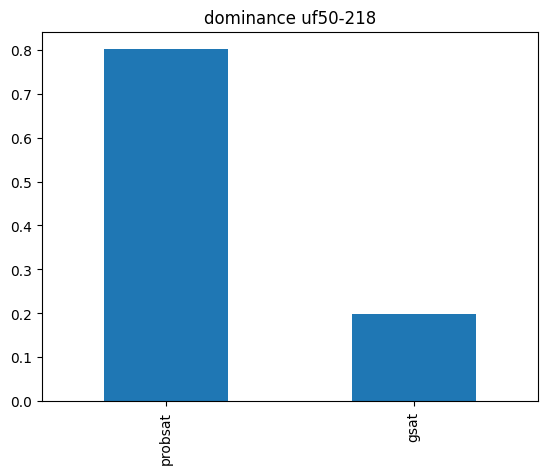

In [46]:
draw_hist(f_df_50_gsat, f_df_50_probsat, 'awg_runs', 10, 'avg steps', 'rate', 'gsat', 'probsat', 'avg steps uf50-218')
draw_hist(f_df_50_gsat, f_df_50_probsat, 'succ_num', 25, 'succ num', 'rate', 'gsat', 'probsat', 'succ uf50-218')
draw_hist(f_df_50_gsat, f_df_50_probsat, 'fined_awg', 25, 'avg fined steps', 'rate', 'gsat', 'probsat', 'avg fined steps uf50-218')
draw_hist(f_df_50_gsat, f_df_50_probsat, 'q', 25, 'mu', 'rate', 'gsat', 'probsat', 'mu uf50-218')
draw_hist(f_df_50_gsat, f_df_50_probsat, 'o2', 25, 'sigma^2', 'rate', 'gsat', 'probsat', 'sigma^2 uf50-218')


f_df_50_dom.iloc[0].plot(kind="bar", title="dominance uf50-218")

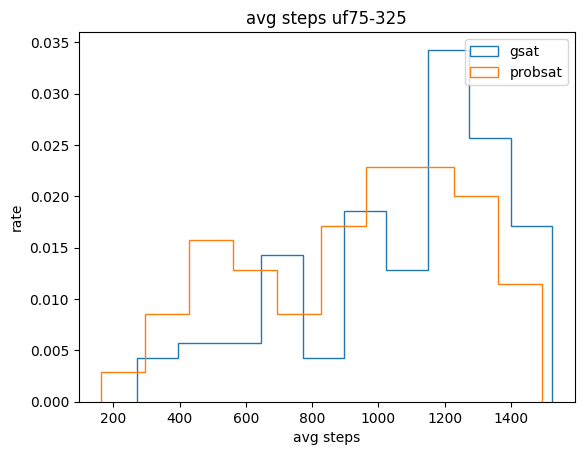

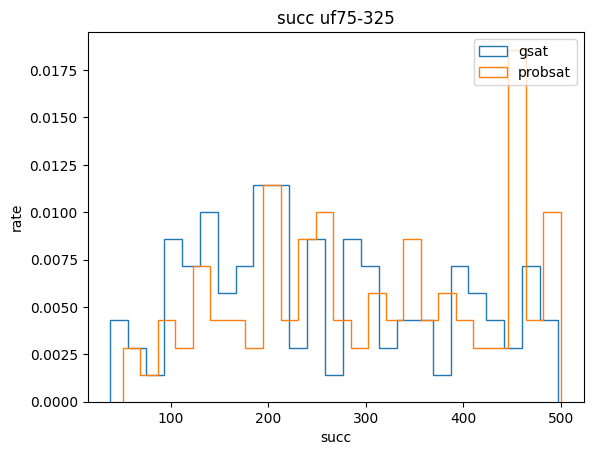

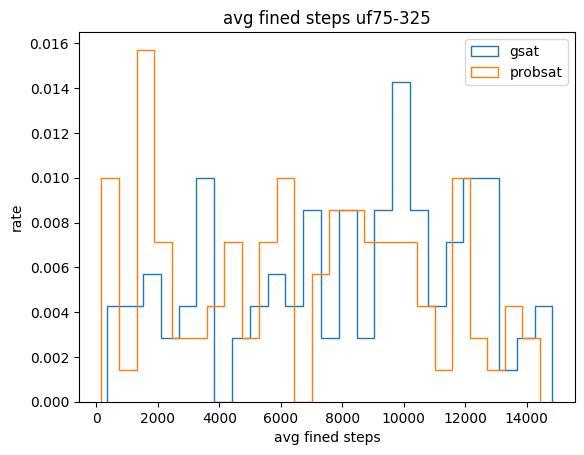

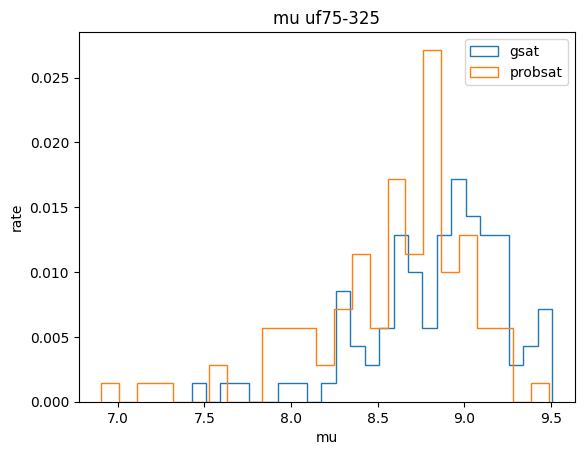

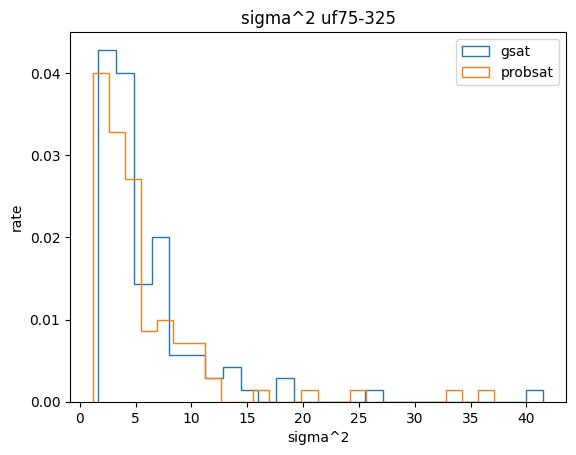

<AxesSubplot: title={'center': 'dominance uf75-325'}>

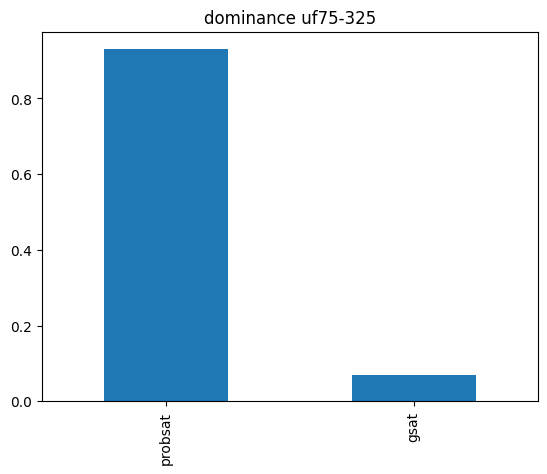

In [45]:
draw_hist(f_df_75_gsat, f_df_75_probsat, 'awg_runs', 10, 'avg steps', 'rate', 'gsat', 'probsat', 'avg steps uf75-325')
draw_hist(f_df_75_gsat, f_df_75_probsat, 'succ_num', 25, 'succ', 'rate', 'gsat', 'probsat', 'succ uf75-325')
draw_hist(f_df_75_gsat, f_df_75_probsat, 'fined_awg', 25, 'avg fined steps', 'rate', 'gsat', 'probsat', 'avg fined steps uf75-325')
draw_hist(f_df_75_gsat, f_df_75_probsat, 'q', 25, 'mu', 'rate', 'gsat', 'probsat', 'mu uf75-325')
draw_hist(f_df_75_gsat, f_df_75_probsat, 'o2', 25, 'sigma^2', 'rate', 'gsat', 'probsat', 'sigma^2 uf75-325')


f_df_75_dom.iloc[0].plot(kind="bar", title="dominance uf75-325")